In [1]:
# load libraries

import os
import pandas as pd
import cv2 as cv
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [11]:
# load data

path = 'E:/DeepLearning/dog_breeds/'
path_train = os.listdir(f'{path}train')
path_test = os.listdir(f'{path}test')
labels = pd.read_csv(f'{path}labels.csv')

In [12]:
path_train[0:5]

['000bec180eb18c7604dcecc8fe0dba07.jpg',
 '001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '001cdf01b096e06d78e9e5112d419397.jpg',
 '00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '0021f9ceb3235effd7fcde7f7538ed62.jpg']

In [13]:
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [47]:
# prepare images for data augmentation

augment = ImageDataGenerator(rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
                                zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

for imgfile in labels['id'][0:5]:
    # read image for data augmentation
    img = img_to_array(load_img(f"{path}train/{imgfile}.jpg"))
    x = img.reshape((1,) + img.shape)
    
    # create randomly augmented images, save to "augmented" folder
    i = 0
    for batch in augment.flow(x, save_to_dir=f'{path}augmented', save_prefix=f"{imgfile}", save_format='jpg'):
        i += 1
        if i > 4:
            break 

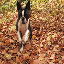

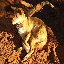

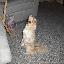

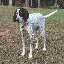

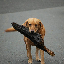

In [49]:
# read and display original images
for imgfile in labels['id'][0:5]:  
    img = img_to_array(load_img(f"{path}train/{imgfile}.jpg"))
    img = array_to_img(img)
    img = img.resize((64,64))
    display(img)

In [71]:
# read original and augmented images

for index, row in labels.iterrows():
    print(row['id'], row['breed'])
    files = [imgfile for imgfile in os.listdir(f'{path}augmented') if imgfile.startswith(row['id'])]
    for file in files:
        print(file, row['breed'])    

000bec180eb18c7604dcecc8fe0dba07 boston_bull
000bec180eb18c7604dcecc8fe0dba07_0_2552.jpg boston_bull
000bec180eb18c7604dcecc8fe0dba07_0_333.jpg boston_bull
000bec180eb18c7604dcecc8fe0dba07_0_4573.jpg boston_bull
000bec180eb18c7604dcecc8fe0dba07_0_5310.jpg boston_bull
000bec180eb18c7604dcecc8fe0dba07_0_7517.jpg boston_bull
001513dfcb2ffafc82cccf4d8bbaba97 dingo
001513dfcb2ffafc82cccf4d8bbaba97_0_2418.jpg dingo
001513dfcb2ffafc82cccf4d8bbaba97_0_3728.jpg dingo
001513dfcb2ffafc82cccf4d8bbaba97_0_4971.jpg dingo
001513dfcb2ffafc82cccf4d8bbaba97_0_6073.jpg dingo
001513dfcb2ffafc82cccf4d8bbaba97_0_9212.jpg dingo
001cdf01b096e06d78e9e5112d419397 pekinese
001cdf01b096e06d78e9e5112d419397_0_51.jpg pekinese
001cdf01b096e06d78e9e5112d419397_0_5710.jpg pekinese
001cdf01b096e06d78e9e5112d419397_0_6844.jpg pekinese
001cdf01b096e06d78e9e5112d419397_0_7216.jpg pekinese
001cdf01b096e06d78e9e5112d419397_0_9960.jpg pekinese
00214f311d5d2247d5dfe4fe24b2303d bluetick
00214f311d5d2247d5dfe4fe24b2303d_0_3078.

0a27d304c96918d440e79e6e9e245c3f west_highland_white_terrier
0a3f1898556115d6d0931294876cd1d9 lhasa
0a409042dd36b2c8293c67d4d4ea9ef9 sealyham_terrier
0a4116a80e753f7b0adf4149f551a3a7 kelpie
0a438069d5a8a8a079ac131d74c3a366 dingo
0a4f1e17d720cdff35814651402b7cf4 afghan_hound
0a541df84dd3febb076e2c33a23cd230 bloodhound
0a5958a7f6836cbe349a4cedfe7178a6 basset
0a5f744c5077ad8f8d580081ba599ff5 redbone
0a65ba3ab9b29c66e15cec76f34eca6f mexican_hairless
0a6706f7864eb8871913f0e4ba07a61e samoyed
0a688b0783f472c84bbfe1c56efea1c6 mexican_hairless
0a6c192b96e55e2ca37318919b1ffae6 collie
0a70f64352edfef4c82c22015f0e3a20 west_highland_white_terrier
0a77b9015c37f39c92b5399dc29da97c irish_terrier
0a77d498ff491945347bb895d8ae4008 samoyed
0a783538d5f3aaf017b435ddf14cc5c2 french_bulldog
0a7899ed6a15f4af8f28e01c9c44dcfe miniature_poodle
0a7f8d31c960071d0d4cfba36c0159c7 brittany_spaniel
0a86c8b48bddb0155645f3a27f48292f bouvier_des_flandres
0a896d2b3af617df543787b571e439d8 leonberg
0a8b6985bbe58a58909b5ef0a7

1383bc8b2db4943fafe13b7f289f4a03 curly-coated_retriever
13863e32053e9735b55ba975ecd58cfd malamute
1392df2ceab56cdf380813987c7c9ba5 bouvier_des_flandres
13932827f30cb00d0cb4c40443c788f4 blenheim_spaniel
1399f1e08abd77f1b736303d4101d51c malinois
139b8328a97a600cceb73b0875f80a98 toy_terrier
139e8120addf833f72a8dc2c12ad4c8a lakeland_terrier
139fc3326016bf24cc06ad898c42742e english_foxhound
13b1ca09a561661a8c1a506d49b8dd83 groenendael
13b5f36cb39cb5123958c6e4fbfd5399 irish_terrier
13c5a0d636619210b5ac003ee82aacf0 whippet
13c630fcf8aa68ab0e97cd4a644b8943 doberman
13c7c6b47b97b9f0a4591fef29893436 pekinese
13cab1309bdaf21aa17cf71fd6f88a65 old_english_sheepdog
13d42ef52eb6c649c14cb9ffa8b6fba4 kelpie
13d470408dbbdc20b38ea32d3752edbb malinois
13e2d0cb1fa62d3085be6877bd7e85cb pomeranian
13e608df9c88b1465ebf98bc84d0a832 bedlington_terrier
13ea49cd2b706ec9a15e7214e492bbb2 schipperke
13ee74fa50b3e32356047fde4fd993ab keeshond
13f6cb46cb23d6eb41fa6931b73b3e4c bouvier_des_flandres
13f765ea64c7a3575a105c

1c32819dd77f0ae25c700670d4d054dc mexican_hairless
1c422e6f57d4227ae5d25b7cdb1435b3 giant_schnauzer
1c49a72fdc9f22fb3efdc3477ccb9282 west_highland_white_terrier
1c4b1ca01852b8ff6fca6debce1fd229 siberian_husky
1c5575083fe9e346d66eac01d2cc5480 border_terrier
1c564272c2c290a83bf4a520359cfd5c great_pyrenees
1c5cf83dbdb32e8bedb5e90d42f653b8 papillon
1c6e8c8d8c8a03b36c82393107afd53a chow
1c6efdb63d5d69d9a40c572b48d21278 afghan_hound
1c76aa98ddb88daf73b28701c722817e sussex_spaniel
1c80cbd184334b339e5eba8aaa6ae929 samoyed
1c8d28b7bb59a685a201e7adbd6d3563 eskimo_dog
1c8d84801448b2a5e352466257197ca1 pembroke
1ca564d94dd35571de3b90d24c6f80ec shih-tzu
1ca84cc3ffbab016dbd7ceced0e680a3 silky_terrier
1ca968b47f96eae326ba0d7428584e6d dandie_dinmont
1caded15d1b633293fb3350238fdcea5 irish_terrier
1cb0e898706f9ce220a52561f5a25f85 blenheim_spaniel
1cb81d1bbaa7d0c550281979b853491c lhasa
1cb97451ed7b29f5328fa1c172c62361 american_staffordshire_terrier
1cbe771a950488b29515e712c8c91026 chow
1ccda12951a853e07cb9

2598525f7e0470d1424249bbf998dc96 miniature_pinscher
259b55fcffdd850aac00d034b090c56c redbone
259bc30c8e5754ff9a8459dd75eee994 brabancon_griffon
25b02d997fb29784ffa5d767cb0481d5 blenheim_spaniel
25b31f36e3c72a6d1bdce88539834b59 toy_terrier
25bd4d37f5af75544bf4571316eb9d1c pembroke
25be8d40afc2702a73cef09dd624a3f0 irish_wolfhound
25c22dead9fb1bf09d3984b2e6ebda43 australian_terrier
25c47bc84760dbb01ca2f96bbce9489b rottweiler
25c795ad08d87a312345e74cf469c5d3 giant_schnauzer
25cadbca01601bb69736e4835d60b048 saluki
25d13706449a0e5bc89077b99366b448 yorkshire_terrier
25d44cc514ac6625b1ea11ab91b4ba2f lhasa
25e39234fec7980d3dbed17e21f4b8c1 siberian_husky
25e4cf89d2558df2a189d4d6e76efcb1 pomeranian
25ea375ae33a9c855b9156570b9844bf shetland_sheepdog
25f99bf9e6cfb22ec1f7b6857bba15c4 english_springer
25fd69a393eb692942f95048f2ba8924 norwegian_elkhound
26096ea4a2c7e6100e4b434ffe57ab2c redbone
260a6a3079eeb47413c040b4ebb4c8bf dandie_dinmont
2617e4f271598e3e74f7e0f94c862db3 rottweiler
261a03537305027b4

2e8abb5831a8dbcbe58d4f53c20b1478 curly-coated_retriever
2e8b303be3212d4085e30c5e0b062c1c norwegian_elkhound
2e8df776be90cef2e363474dccd92cbb welsh_springer_spaniel
2e9b376c5f63e524a6127db865476acf bloodhound
2e9be023f054bd4139ea30d699008be9 basenji
2e9c04fbf919d4bc2222a64fb15bad75 airedale
2e9e96fc941177ecb045802c53b8f368 chow
2ea0a5df97a6dbd3a5cca32bd442dbe9 australian_terrier
2ea147dd52c8e098ef66317a091fd8a8 tibetan_mastiff
2ea7b5bd523c32ee7d66a8c65e9c3931 standard_poodle
2eb1bf4abd7d1b7868afbf0328597108 leonberg
2eb3b65b71b57828b832a7ade0ab33fd standard_poodle
2eb4b684bb0708cabcbc15eae72a539b newfoundland
2ebaa578b5b4680c56ffea593b53cc75 saluki
2ebd03cafba22edf2556cda2a6759e19 toy_poodle
2ebed4a14973b0211b5802b15a3bfcf4 kuvasz
2ebf9f6ed8dbe3c348b809987f8e0c02 curly-coated_retriever
2ec08fcce1e1e8a126887620cd74942e briard
2ec0a4f923fe7c039a74a2e2aa0b0152 norfolk_terrier
2ec97036f595eedb9211436195abc0eb ibizan_hound
2eca4c81f5fa27c12429e2f7ca14dc2f newfoundland
2edc0a97b26c976df89f7a3

382321aa611762ba588d18d3f826db20 bull_mastiff
3826c9b17af94040d0fbd7a334f2d379 whippet
38343daa2a67c48067f0f5e12a95aaef greater_swiss_mountain_dog
383a4848931aa3c6c8ba315bdb6ed4ea pomeranian
383a9cc4522b7776d520fc30d4fdbaa4 siberian_husky
3840bb3ba6180a8d42540061cd28ed18 chow
384b73fc513c14ff4f72ad236fffee3c newfoundland
384de1984afb60c19cacad0df9851260 flat-coated_retriever
3852a02cf19ae4141fd6746037e85cb9 greater_swiss_mountain_dog
38561c8b2f9f72d03c960e9831f9663d standard_schnauzer
385b3e25cd3148633576070e2c10969f weimaraner
385dfd666f34212de5fee77893fad23c standard_poodle
386c700bbbf89c2aa068692d83e3a6b4 keeshond
386c91e7a3af342c031aa34fb1bfdf4b norwegian_elkhound
386c9ef54712d0218980b38219378ac4 great_pyrenees
387603961b4002a45c703147e086760a pomeranian
38770f3ab4151fd8ede7c924752280b3 saluki
387ad9acc7b29f2f25898dc06e8d2fa9 italian_greyhound
387ae4422add8a82e27f14da3b778a5f saint_bernard
387ae89153da8b0171322ab0cd54923e boston_bull
38882b8de9be438399a511e6bd619268 giant_schnauzer

413699c1f7cf1b34520b88324b49643f west_highland_white_terrier
413764ac4af585e252f48e6ac2482c6a irish_wolfhound
4137b32e97452182bf21a4c5accf8daa kelpie
41397398c9a57e8a11dc9c1d898bdf8a maltese_dog
4144b660e077bbc348b8ef1125185194 irish_wolfhound
415a7226f175bcedd768b38bc40af498 german_short-haired_pointer
416f36e236378210a7b553c0717950d1 french_bulldog
4170a9e32373fcc2e178b5a357cc849a kelpie
417b4a513d4a07f4040edc84dc23df9e english_foxhound
417e5069354eff32c8fd13729a6702e3 cairn
417efae72babc6847bc551654d339ecd tibetan_mastiff
41877ee88e78ee4021a844c1c996f73f otterhound
418b16343949c0055f6357f4314b99aa dhole
418c55a9e57547d423ab41e5fa3c7bcd redbone
418e24eea6f52ea47c7fa94dc1e88d09 miniature_pinscher
4193da9e92c9a34fbf6554cf42e4d4b6 norwegian_elkhound
419a994803b6436b2ff3220b192b883d pekinese
419aebd136f49997714405dad5ec6b23 wire-haired_fox_terrier
41ad1e6c01fa12d530a1122faaeb2917 groenendael
41b02dd6f93364e6dd699ad7a59db8e6 rottweiler
41b303da4d541ba4b8d9162881f706fc bernese_mountain_dog

492d16aab0e9c7b6e68093202ec1cb61 lakeland_terrier
49316a21549beb0106c4ca7165d5f390 gordon_setter
49353ee8314c786682ae5cbe9f6f227a miniature_poodle
493cafda8f5871aa73c815ad6bdcfda9 bernese_mountain_dog
494935802ea0cd133ac9e7cc8a7fb72a miniature_schnauzer
494c1b8a01452a4bdd996786aaca52bd miniature_poodle
49505d68a14b91047e77fdb8361bc5d7 african_hunting_dog
495b7b4c6b37540d443d283fb7ef3fd1 airedale
496d44265b7d32f2ac1648e1416a247c bouvier_des_flandres
496ff6d8b62644b35c39b735e95887f5 bernese_mountain_dog
498c124f07f90a5f911a8879a4b53444 scottish_deerhound
498d544cd0857984fa7d10edd80cfd98 dingo
499174e0769fdd49fdcb69e235927bef maltese_dog
49991f0ff28b99671bcf48f93957b0a0 border_collie
499e40bbba7949d34154a08c751eac97 keeshond
49af83fd16a3b5364b1905b231a40f39 irish_water_spaniel
49b2612ccd1de03df55c923c66e8b77a curly-coated_retriever
49b3f86003cd0a64d219862067cac95d beagle
49bf6b22eb085496861f0942858f99d1 cardigan
49c436d99eb7b25eb4a2222122854242 irish_terrier
49cd12b943044687bb3b8ad80df7e1

53efa969f346dbea87b4629deed66aed rhodesian_ridgeback
53f55bd1db61a777322184bbde411466 newfoundland
53f89cf0e6bc883462dc5a147462fe37 soft-coated_wheaten_terrier
53fc7ac7521c719e0efd5f509ca5e928 norwegian_elkhound
53fc9ac8e5f21cd52297f44af13ba52d english_foxhound
5406eeabc4f6b981cc6f61cc7a335eae maltese_dog
540a64ab0a107a55d2cc0f8d2041c2c0 kerry_blue_terrier
540b586c4e59e4287e018bf0b019aa90 leonberg
540c37123625bae630876c20617d931b siberian_husky
540d23e6afd472eff803353d6af6f323 airedale
541454486d3fd58e7f2a9c458596cc22 chihuahua
541f7218023e5f77a5cc5a915b0e808e saluki
5431316ec1ca840d0a7fbb7e7d15edbd tibetan_mastiff
5434d4b405e947aeeb94c141df21f008 pekinese
5441212c564d93e51eff4498bd46f3f7 toy_terrier
5441a60725f87efa0862ef9416c28481 cocker_spaniel
544dcc6d81190416abfcaa1cbf9c978b miniature_pinscher
54656e8a4fcc7c6d6c36579a8135231e basset
547231618deb73591ff006835eb13765 pomeranian
547d9b623cccf3a262db4b35f0c28e2c norfolk_terrier
547e9cca520970b35c1d9acb0a0fb902 sussex_spaniel
549144e54

5c79f8b596036c75fbc266289e4cc46c miniature_poodle
5c8c894495971a65f0a179bc4c0ca0bb wire-haired_fox_terrier
5c9055942e39e8cf473e234e5b77139a soft-coated_wheaten_terrier
5c9286aa8acd394e41688b8d4fe105d2 curly-coated_retriever
5c9cb6499e5ba2559dbca47cac46536d west_highland_white_terrier
5c9f44926bd503111e97b4e3ee5cc0cc shih-tzu
5ca1ffd7a6d09951f5ae0afca1635b02 chihuahua
5ca52df98ea1aaaf527d1ef4df6faf3d english_setter
5ca5a2933c672c6ad48d373452701289 shih-tzu
5cadfec7e208c688354844dba4befb92 soft-coated_wheaten_terrier
5caec584711f18a8bfd66576195b38df redbone
5cb6352230645e22549b93cb62a3c28d brittany_spaniel
5cb8e8855145375221015c02fe21b273 affenpinscher
5cba54c8626c411bbc2284058dafe048 cardigan
5cbc1c6e10458a596cba3dad5de44c53 black-and-tan_coonhound
5cc00f927f38bcfbda41d1fc4df9b755 norwegian_elkhound
5ccc97e47bb1878de5b003a86968afe6 border_collie
5cccdd466a3a1430668f10ac14fab212 newfoundland
5cccf8e7b1c4a17fa7b79a069533dc22 pembroke
5cd231784d822f0e68721536c40a81d8 samoyed
5cd7d9abb1a7d0

6606afcb1331c43b7fa96ae2519e6d19 malinois
6608429a87b9395181c7f500f2ead9ee shetland_sheepdog
660e3d56105b467159370bc1bc5e469d weimaraner
6619c7edde89e485a06807219f546e22 blenheim_spaniel
661a470728de5c694ea87211eb1c6738 vizsla
661aa568147bdba9ddf33310ff0783f4 staffordshire_bullterrier
661bdebb4861681d269841c2e7b69948 japanese_spaniel
661bfcaf851383a9279d82316c5effcc norfolk_terrier
6620cb2082fd57c0c56f2e4903b5339a basset
66246162973426de2172eabb2dc84f43 english_foxhound
6640360f7db7c2a66818400cb9a290c0 basenji
664fcdf9528464aee007c046919b006e chihuahua
6663a212ef86a6f17ec404d399590daf saluki
666a1a9ca9988f99edb362e50428eb65 whippet
666eeaec16b885a3b9c11b9a9c5e8cbf soft-coated_wheaten_terrier
6680c9c925076285d51b5676d9e13b9f german_short-haired_pointer
6685558aaa49755e998feb063cf9f42e curly-coated_retriever
66913fe7aaeedbaf22317d06d7a1d0b8 welsh_springer_spaniel
6693857d0d28517977ee6b00823a4074 welsh_springer_spaniel
669d0c285f652eb96a97f45b8c7f1bb4 scottish_deerhound
66a03a70c6e7019161

6f3d31094ddb18242cc01c7d4934b163 airedale
6f3f29c37500a418da5f974dd9563006 kelpie
6f3ffaa96d2f7c365d40f71dcbca6336 keeshond
6f59969a22373428d7c9d9be9ec98461 curly-coated_retriever
6f59b7fe7cec6043ec57fcc89f893140 doberman
6f614bff9db3144e74406fb737fa6d46 dandie_dinmont
6f6165a3bdb6fc37a4f26f858f182336 labrador_retriever
6f626925348bf731ed990937a98bf8d6 appenzeller
6f68ebaf89c39021195ce96796fc83ae tibetan_terrier
6f6b3a96442e671c9cb62815a1e87dfa pembroke
6f7286e4adbb6f2f066eb47a87f92554 rhodesian_ridgeback
6f8095672995666a0d6dd4e7daadecde redbone
6f8344c982a496e159ea392a0a1cd417 german_short-haired_pointer
6f85e9e2824f09e392782698fc57090c silky_terrier
6f86de5ce20b6ac43e0c4387a8014d26 dhole
6f9bac41b5be5ee6baecc9e7ef8f2c2a golden_retriever
6f9f76d5b090ee0691154de6cbc70c2f pomeranian
6fa11f3d4cd5e972b5be8a871674017d sussex_spaniel
6fb144599ec91a40edeac0d884ff43b2 groenendael
6fbbb4c3e5619162bfee38128326a55b english_foxhound
6fc044de6c66fa7c9e8b9484ef2d2521 pembroke
6fc396bea6794e80bcaeae

79b05087af93c305981bfe509659391e cairn
79bef9a1aebcd3246ec1de034107dd87 boston_bull
79bf1625004cb49fbeb98e1ba0dc08c6 clumber
79bf450241ac44efcb4b41220275fbc9 flat-coated_retriever
79c132b5981112afd66ccf194005be1e komondor
79c3812790eb28056231448106959e8d irish_wolfhound
79c4b258a57fb46c58b749d093bb22ed saint_bernard
79c86fd29b3a3114546150b748eed6c9 wire-haired_fox_terrier
79cfdadcf7d192139150d23f49041aa7 afghan_hound
79d2ea336fda1392771cb594f3555945 scottish_deerhound
79deb223049ef9f441f3fcf989897d29 great_pyrenees
79e176c35318c7cdb2db59366726de77 west_highland_white_terrier
79e5a57747f01674c13c7808a8182387 giant_schnauzer
79e5eceb21f356f2588ae36ec2c91599 kuvasz
79ebb7ccc1a5d29593f913210c36118f tibetan_terrier
79f19e141ef77c11376a2ee137ecd731 greater_swiss_mountain_dog
79f802428ab1d8e15f3b6d0d9c49a1c0 ibizan_hound
79f931065bf961e6251c37d890658116 irish_setter
7a06c76962e2133762b6e1e10b440d63 whippet
7a0cfd6eb2495b5b25d6efed110b737c mexican_hairless
7a11caa83f363f20ade587ee2a6b2e22 iris

82eef71387371d728a62b97fcc5ea59d bull_mastiff
82f07b15ad87bcc8e3159288062e318b eskimo_dog
82f33433170f776e0625acf56e1b63d3 groenendael
82f7c3fbdbdffa5a8f3d95396b4bec66 italian_greyhound
82fde5fcaae01023c6625fabe6bf8637 dhole
8310396eb8dc96ca5288ba74571f0bc5 malinois
83133ae1da7df4cc231760e84dfc2f63 whippet
8313f9f0f044f5a5cf328aabc806d01c curly-coated_retriever
831b3e2e2fec0aef8e3527d5af458b42 doberman
831efcef1f4cf4837279d6e01becc3cb welsh_springer_spaniel
832093e19f5d6f3cd38eace5414d6249 scotch_terrier
83217877553b0d7ba501cf416e4b7b8e standard_poodle
83217ef19550d7e7d08d0aecce356baf kerry_blue_terrier
83254997246bf8de94b214e270debb07 african_hunting_dog
832dd63427bca3afb5bc86f1fac57dfb bluetick
833adc79c13a4c2d232c3395ce946ba9 kerry_blue_terrier
833c7a225f090de16937b248422402f3 bloodhound
833f34f8c542d816fa5c9c010c604680 border_collie
83419e443823a02af76822806bd12900 afghan_hound
8347ff4200278ebc03d010d7646dd767 bernese_mountain_dog
834c4d710ee55585b89940b540fd9edb english_springer
8

8c99f1d9dde16550e002b8ea3fc342cd chesapeake_bay_retriever
8ca7a862f8419c130ea73917d12dfce5 bloodhound
8caee24979a5ad8887ceba75d93f0ab6 beagle
8cb6a74c34257a22665589648d827aad kerry_blue_terrier
8cd3fb35c72d692d4c717b6052465f55 kerry_blue_terrier
8cd4a3412502ee82680eb4761d68d0dc dhole
8cd51950e3f5d3d119d195bde1eea9ad black-and-tan_coonhound
8cd5ae0663d2d5fbc39f291a99f3ecd2 english_springer
8cd7532d405da73d94dedca7e887ff92 scotch_terrier
8ce5703ad6a594ab9ba7540964789fe4 black-and-tan_coonhound
8ce94c7eec80364765b1c21f440a7f9f doberman
8ced482ceedeccca651a81a15ebe47bd redbone
8cfc893064157fb61fc90bf9a5ab14dd scotch_terrier
8d06f684b12bf2c64375acf001cd8285 japanese_spaniel
8d081a85379005be35b81747dc8873fa border_collie
8d0f47344bd67acf7ca366190aac064e wire-haired_fox_terrier
8d19a2d1a7027646ed367ec35bfe6b8c irish_wolfhound
8d19b5c9f212ccbc4df8546c7a572919 affenpinscher
8d2dc9668eadcd1eec60c27a9680c45f saluki
8d2eba220c4199ebd37db6bceabf4969 miniature_poodle
8d32ca9b3faddc11fa5488ab18b4cefe

953fc878b8830cb73c0cb9c58a0ce2e1 miniature_schnauzer
9547e29629c4d7f523eb1366a1ab4def briard
955677ee4ce177492ce886426271f831 walker_hound
955aa14970c097c30fec72f106e4cb44 pomeranian
955be2ac08466bd001b285ee907670b6 staffordshire_bullterrier
955fdc8f29b6b78c8888d0dfdd1c6a8d mexican_hairless
95660f727282e9db785ea010b0dd4160 samoyed
957e390e19baa6d163079835a28155b9 basset
9584bf3b986648ffcfd08f27b16d3c1f basset
958695b0c7323ac786ec86f6f1222eac dingo
958f26d170394045f98ab3278a4f2f8c cairn
95a35be5b90604e39e5177723ca0b348 affenpinscher
95b04ef45b853922685ba6d257fc2f0c japanese_spaniel
95ba2022991e02fe0cfea89fe8ae6f5f english_springer
95c246b63eb7f6c5312181d954d5d01c vizsla
95c9870d3e06e1e640e6e39daf65e25b boxer
95cafdd4b2f6be2ba46c472c2dedb98f wire-haired_fox_terrier
95cbfe6dad49dbaec7230f270e968603 miniature_pinscher
95d1224b21964f4fd5a4033e3bf3384e cocker_spaniel
95debc3253f72a005a8473afdd06e730 pomeranian
95e04c4e07aff8b120404927e30ffecc shetland_sheepdog
95e82d8ad15c46cb1bb9d4fb439ef62

9f66b4be4892cdec9c0d53f646195b04 bloodhound
9f682747d236dbaf8c530933e5dfcb44 bernese_mountain_dog
9f68d045a396679a778eb54c5ed29038 lakeland_terrier
9f6a267ebf271f72f91ca0a97d60a90f basenji
9f6c4d16ab3154ba2f57cb9d7f2af40b shih-tzu
9f6f16bf36bb2d9a144f70ce09404020 dhole
9f70486e63ac01868d87763df94226ec great_dane
9f705b2db2425e112e4ceefcbaea7e03 blenheim_spaniel
9f784b4b261cfb7b398126e2077a997b pembroke
9f7a6cc0713a2984947db2463b999133 irish_water_spaniel
9f7d5eb41b3bfb57db764b6d6049da3f appenzeller
9f7d62f1f74eab82149843a32ff8ec9d schipperke
9f80e62e65d0cdbde6647f054f12bbef schipperke
9f82e181388d76f44066c05f3bf6c67a newfoundland
9f89f0711c1781582859ff9aa3b12906 sealyham_terrier
9f998d6174571017fdc6e8c0ee14cadc standard_poodle
9f9c35c4628713c82de8499119c06850 australian_terrier
9f9c667f8eb625df654915087b9746ee saluki
9fadb3a7aa97e0c652a99c7939d92875 japanese_spaniel
9fb14d359862987b31fee92145566e70 malamute
9fb9ec152d4262348922fbf4c03f6083 border_collie
9fbbb409d665cd228436cb2c7cfff39e

a7035c27920c29332a8b12cf0d03aa90 lhasa
a705cbd42cf04daaef1961ebb9b50d2b sealyham_terrier
a7167022b4c41ddd1d4aa8e5c18162d2 malamute
a717381e64525267a879ea44f0b76a00 malamute
a72448bdbaa5e486245d38f50ca37e42 scottish_deerhound
a7295fb63568fc0b1bfe4900835fc159 saint_bernard
a72e256f9b65b1b0ba527237f204d77f rhodesian_ridgeback
a72e49a69c8409fed67c47bba4c4f1c6 boxer
a72fac01497e296e32fab4192df57531 ibizan_hound
a730da7fcd2f9699ba71745e8b5256e5 cairn
a73d4f5c3ae0eb8dc94321d0d342609c sussex_spaniel
a73f41b13b33cb177001a55a940505fc american_staffordshire_terrier
a744f11051daf6c9bddc47fd757d0bb6 bull_mastiff
a745bd8479c64408093c2116a58e38f6 groenendael
a7478e4233a1b25de97d72c9b48f0c0b border_terrier
a7488d6640ff1fe321e06bf0559f3bbf miniature_schnauzer
a74b32169c1b42a218a9f72f954ec9a4 gordon_setter
a7551603593a58e352ecc73d487fc7af komondor
a755566f4f69456d4a5a192511bfd744 lhasa
a75a772a44c46e03333878c9cef8d81c great_pyrenees
a75dc89b84b4986afa0365ae9f734681 walker_hound
a768d7fc2b42dc15018ba9641

b084d252acbffe3520120c45314ffeb7 kelpie
b08e4205506dc41bdc7ae8546677bb68 golden_retriever
b091cbf14b893d3c13cea2b1a8cb503f great_pyrenees
b092be3d14897804d887ba436f9ddcb7 vizsla
b0a63d52383934ed0caec038dbbe7d92 rottweiler
b0ab7bf62ba55c1c4a6b037132576cd4 kuvasz
b0b2a18852c2380285649efd5947f408 tibetan_terrier
b0b2f68210c947e1365d9d8687bdec0e boxer
b0b7aaaa673295ace0ae4d9f248b71f1 siberian_husky
b0ba782b54de66ab1c3a340b5cfd9d9a keeshond
b0bbf2fba6147815e11b198902e35aa4 lakeland_terrier
b0c2de19f94d48e6d0c05b2c61effe74 otterhound
b0cbfe76d07597b948782dc3c74cdf66 great_dane
b0ee2f2ae56110de3409f31e26a8704a australian_terrier
b0f80934881f210a6cfc50e425660ac8 australian_terrier
b103316ae94567dd01890e7fbbee90e2 cairn
b106bb7f5c07cfdd55f979ae7a83a41c malamute
b106df46d6b5fa931d0913dce8a46362 irish_water_spaniel
b120195ff2d099b37987f076a5c1078b schipperke
b12779f9c69a049eaa53a01919942d55 entlebucher
b12ca57dbc800fd7caf1327516b4fa1b soft-coated_wheaten_terrier
b13299a4da33368f9d14b3ff6ac0eb02 b

b8e09f10cfea58a7bdd11c9280f0690a keeshond
b8e233e679db8a5e7bcdab32c3d891ec italian_greyhound
b8e73b52fb1d13a6c4b978358c911806 bluetick
b8e77ec7272a78a3340dab5513917a85 cardigan
b8ebdd7228a8cc54e064aedfc5860757 sealyham_terrier
b8ed5c550941c7fd275f1aa07e242f16 chihuahua
b8f03e7c0df51e41d8ef79d9d90df144 briard
b8f1b0d8fdb130de46b61a34ef0278bd afghan_hound
b8fb19ddc7d9973fc1bcccb5abf8ff22 lakeland_terrier
b8fd495e7565e47123ef1500113942c2 basenji
b901180f89399824b9bd0dc8a2eb3a30 ibizan_hound
b902b671e9b94bab23b5f559194b6787 bouvier_des_flandres
b905b9008e830033dedadbda5102f409 cocker_spaniel
b92326736c446df97a64932c02113b47 african_hunting_dog
b92385d243ab068cccd12337210af6b7 old_english_sheepdog
b925a34373763d846c1438768efec3b5 great_pyrenees
b941a00fdd9bdab17af68eaf935a1690 flat-coated_retriever
b9442ec825000b9b061cd71ed5eac36a groenendael
b94652e2a663106e16ea174e5797b49e redbone
b9469cd11471bab7e748e5fa5bf4f157 pembroke
b947c09bf1e90896085a59299eeb8f2f basenji
b9480efcc378fcc84c6e939dbf

c33eda1d0346155ca7a6c8f03121945c soft-coated_wheaten_terrier
c34297e6db453a12e69c2ff3a107125e cairn
c3487bbf17be7def166026f875edbdc0 saluki
c34f899f92484db897374e9567eda5b3 black-and-tan_coonhound
c351c6388350e97f13e22a482b91c6d2 chow
c356c52c408f1099adb4a106718a2935 clumber
c35ca6430da03f82df091ced49f0b07e australian_terrier
c36626ef165cd73783a2e760aaa2fc72 cairn
c3664530805157a7230319d164ceee95 english_setter
c37ce9e2e471477f053b69eb39fb5535 shetland_sheepdog
c37db8384c30b6da21ee2879eb54ffee australian_terrier
c37f52e1a8288a9bf678b19f1e4f9bfb irish_water_spaniel
c37f92c33db324963a0a00725b8e7172 clumber
c3811d9749d6526bb0c415e3a1476a06 doberman
c382eb18b911729652590dd12628dc24 boxer
c38369fbdcdd27f1cc723181df8b6330 german_shepherd
c388a84f93ba4fb28c7b1a7a880474f1 lhasa
c38e77ac6a0ee0c8ff5fdcd1df42f6f0 samoyed
c3912710a89f0e88320b8fe07578a972 airedale
c397eb87347ad681ec1b72f9cf5b5007 english_foxhound
c39c3cb599426bfa1cd2ba7e9604d463 whippet
c3a0166a2d77b608de86c14739d84ba6 miniature_pi

cbb65152c8e5dfbc10ec40421d65956f sealyham_terrier
cbb942c46449834575961dcf0d2c27f0 japanese_spaniel
cbbdb384a6fb8b9b96b598ca1d4675b4 keeshond
cbc3a36f42d9c1a97577354bcde3716d otterhound
cbc467503ed345317daf97f6f5536195 maltese_dog
cbc950eb607d8744ee953bfa1221a895 miniature_schnauzer
cbcd2646088a01dce9e5dbabce5aca3d entlebucher
cbd3c747a40068089dfd7036ff3c62c0 norwegian_elkhound
cbd8e6c8f98e12a8b336ecedfd874707 afghan_hound
cbdc00279f7aa7424d7034ed5463ec79 newfoundland
cbe1e05f5c6a9cad9e5afa6e86dda4c0 papillon
cbe3751367be368a090cb0b160bd7bba bluetick
cbe63371eb2c2c9fb234a64f8bc149a4 tibetan_terrier
cbe74cdfb13fdd3748c52629e38b1588 collie
cc08970afdec42e3c35ecdcb82b88343 miniature_poodle
cc09a186fc07dc960dbbd5afb464c2f7 welsh_springer_spaniel
cc0ad277cc5f3474c3f337015643c6e6 chow
cc0b22a383993745090aeb391272cc77 maltese_dog
cc12832a69a89000c395c4398b72d0e2 whippet
cc1e070f808bc193b981e3b1b89d7173 dingo
cc315850f2853fd4e63220e774672ed9 african_hunting_dog
cc3aae66ef2abe212cc5f682e71612ff

d5dc59aae5cd233f9d03e10ec567ac08 samoyed
d5f0bb0a30174fb308fc79df04ad5ead japanese_spaniel
d5f0de591ddb85ac62ae785fb3e316e9 whippet
d5fb95476c9b8333bc06ecb81fa60511 eskimo_dog
d5fc64a6e484b5ea765358bb74aee4b2 whippet
d600da0fd3fa1bde3ed69e1442aed8a1 scottish_deerhound
d612ce8febeb6a1d74add4669a002530 afghan_hound
d61a270df934b36a3d04fa329ffedc89 cairn
d62be3aa1b627562ab1b85ce73f9fede boston_bull
d630a84482a95f1f4789b816c268ab1a pug
d63348c8d835cd499da54d8de6a11803 tibetan_mastiff
d63508200d0c38766216f3ef91cc59d5 samoyed
d639b33dd3a399d201f995b8d9915a62 maltese_dog
d63acb5d222016e636daaf98d6b2c810 miniature_schnauzer
d6525a312a447edce56a6a10c8741afc borzoi
d654df8cbee8ba4336355a692a3b8468 malamute
d6574a7c2c804a33cf3d29d917923349 welsh_springer_spaniel
d65bc49d1cf6be1fe8fd5798c4a28e08 bedlington_terrier
d66104727a2a8cdfd3f3a0fb17bdedc9 golden_retriever
d66ec4c83a620cca6ebf05ab9d162fcd cairn
d67195583fae5a5cce6fd767ccddede1 blenheim_spaniel
d6857f130c251f01ab973358cbfccce1 boston_bull
d6

df464ebe3f311744241cb3d9258a5000 flat-coated_retriever
df46a6469c374b869375ef18a34bfe35 schipperke
df49b6b0d9d61736047884253bffbf46 great_dane
df4d0576d927992df06c9bb08bb9bac7 welsh_springer_spaniel
df6731703d42db260e3b070fed033e8f komondor
df775558457f8fc42f50a1b944d89328 basenji
df780bd081dc94caf4d1b08583fcfb99 chihuahua
df823d73ef4bdeda8b61e3435db0ee6b soft-coated_wheaten_terrier
df83ac04bc6a6891fe79d6e9b56c391b vizsla
df878b8c7162cab57b3f9e32c595b05f afghan_hound
df8895a945ab874f4a9cdd451aebc011 french_bulldog
dfbeabe922f09fa99ce84c6a94210279 italian_greyhound
dfc12676704c8931010ff087e117d2f2 redbone
dfc362b94e5653a508ceaf63d6b1ffa5 otterhound
dfc726ff7000561805073a11d0d64178 afghan_hound
dfc97c3d7a59ad4d89e791e6ab14c49f boxer
dfd42ce694fd4af24a71392b94176b56 leonberg
dfdb153c5100737c782c5f9578717594 basenji
dfdd8b613bbe040dcd583ff89d71aeda malamute
dfe45c3b288b8224eb17dbdaf1706496 irish_terrier
dfed11d5d68bd13d8587bd3047ef8e5c labrador_retriever
dff884afad091397ca26465ffaa75084 ca

e949de04a40965ca11bf4bc387cbcaf7 blenheim_spaniel
e95bd9ab625ad1c16b513a13a27c447d beagle
e95daa31113477bd93955ae4852dd46a staffordshire_bullterrier
e960fc18473c0998c1ecbda887aa6bea siberian_husky
e96a5909f47824c1410fd00e3bc23f4d chesapeake_bay_retriever
e970fc0099be12ed7544a6eee8e3a9db tibetan_mastiff
e9711a024b141baa00e640231bc461a9 welsh_springer_spaniel
e97344d98c999f4f9bfa5dc33ca09ecb papillon
e97b337794ab4b95db5e2622156de547 giant_schnauzer
e97e598576bbc9adf772f244870d4c7b leonberg
e98505488dfe161e0894e1bce7b5de04 cocker_spaniel
e993788050a70ef538c396f582c3a04c bouvier_des_flandres
e994ab08b7d68114beb65a3784c08be6 african_hunting_dog
e996402cf7fa66f23a8415c9007e06db greater_swiss_mountain_dog
e996b051ab78dd47c2ca379c70b6f27b pekinese
e997eaa38f75d7660fd6c488e3c76d72 tibetan_terrier
e99886bf590f8e0cb3394f91e8920ae2 norwich_terrier
e9a3813892432cb6d5c771156b4bb3c5 african_hunting_dog
e9aaa8964f450f990a7a3c4228bb844d bluetick
e9ac785eb7c5e7c31dd54be18e40bff2 brittany_spaniel
e9b8e25

f24f230f4a39f5411546ab1da48cc196 gordon_setter
f2580ac6cf1bb3317c661133fc3bc7b6 blenheim_spaniel
f259fce0c617f40d26b75947f71f489c old_english_sheepdog
f25a4184e33741e745175fd1d7c6d172 rottweiler
f25b4df00f4afe17ad37fb49a86c9ec1 sealyham_terrier
f27909f3037a7b5443193d7101277fb6 irish_wolfhound
f27b4323bae39abf810bcd145d8de276 staffordshire_bullterrier
f28c40401e84e41f5aa4c60fea02a575 yorkshire_terrier
f28df9c49c705281298bc288ffab24b2 boxer
f28efce22982ed7867a67df7d0762c58 english_springer
f293c3e2fcc58e1d539aa71c56be8d55 papillon
f2ab1692e3ef27cffb8cbb7ad6d99092 french_bulldog
f2ad1868e6784b428fdccffe0314867f kuvasz
f2b4247f7397d329557b0356b5645e70 english_setter
f2b5ba1f32494b942731fb5248e114a8 keeshond
f2b70abdaeaae871fba924ab80d3253e brabancon_griffon
f2caac437e0ad55c130321aac6ba375b samoyed
f2cb6f6dfc542d47bfcea63b0dd78c6e brittany_spaniel
f2d229962b94228f494c9cb3c0ffe740 labrador_retriever
f2d2443edb0bffec560ed1339613503d english_springer
f2d5c11258efb9e8de45a81a6982f8f2 irish_terr

fb80f89c84c6c2649964b574918e02d6 newfoundland
fb888e2a6e2acca312352030cc8b24de irish_terrier
fb8c009186d200c2f49173d89f4a4a80 sealyham_terrier
fb9ad84feb0f23f26247056b830f6e36 irish_setter
fb9c8b7e0b70b201898d930ed71163b6 tibetan_terrier
fb9cbd60c09b65c1032fc7dab93c8354 miniature_poodle
fb9ee245256bc5c3e14f32c8c69cf6a8 pug
fba676383a9e3dd93dc1c4d50c54f48f norwegian_elkhound
fba73e53151cb751f9c22e63de669923 pug
fbaabd8210413b2084743c1f00d8c0f4 papillon
fbb02fe9f6a18d5e59c93e957dccf4fb affenpinscher
fbb86c8f93d2a1068520c0363a2079bc japanese_spaniel
fbbae3a9f939903eb81b3d86ca4a8786 chesapeake_bay_retriever
fbbe0a41f7fa5cd4b69f25d8693e55f9 scotch_terrier
fbc14efa3d420a5d5f4719a356446ad4 newfoundland
fbcc2af005aa6fa3c9cab4d1ac38bf06 malinois
fbcd86965ce247c0a44e50ff7b66a670 entlebucher
fbd5762e97073435f8b7942fc67a4d16 cardigan
fbd70c8820a6fbcd21242284baa8ba27 shetland_sheepdog
fbd75ba5bf5ce7ef08a11a69c5ef263c vizsla
fbdeba9ec017fc43c814e2688ad62402 sealyham_terrier
fbee719275e23f753f3cd1d9f